In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from PTI.ReadDataFiles import PTIData
import PTI.SpectraFitting as spec_fit
import PTI.QuantumYield as qy

## PPO in EtOH (Integrating Sphere)

In [138]:
ppo_prefix = "Henry/Sphere/PPO_ETOH/"

# In order of pure EtOH, 0.31 g/L PPO, and 3.14 g/L PPO
ppo_data = [PTIData(ppo_prefix + "EmissionScan_ETOH_ex310_2sec_160830.txt"),
            PTIData(ppo_prefix + "EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt"),
            PTIData(ppo_prefix + "EmissionScan_3x14gperL_PPOinETOH_ex310_2sec_160831.txt")]

baseline_ranges = [[300,310], [450,650]]
emcorr_wavelengths = np.arange(300, 848+0.5, 0.5)
where = np.where((emcorr_wavelengths >= 300) & (emcorr_wavelengths <= 650))
emcorr_from_file = np.loadtxt("PTI/correction_data/emcorr-sphere-quanta-interpolated.txt")[where]

ex_fit_ranges = [[300,320], [400,600]]
em_fit_ranges = [[330, 600]]
fit_wavelengths = np.arange(300, 650, 0.5)
ex_fits = list()
em_fits = list()
total_fits = list()

ex_int_range = [300,320]
em_int_range = [325,500]
QYs = list()

emcorr = True
for data_set in ppo_data:
    # Subtract a linear baseline fit from the data
    data_set.cor_data = spec_fit.get_linear_subtracted(data_set, poly_deg=1, list_of_ranges=baseline_ranges)
    
    # Apply emission correction
    if emcorr:
        data_set.cor_data = data_set.cor_data * emcorr_from_file
    
    # Get a Gaussian-linear fit for exictation portion
    ex_peak = np.max(data_set.cor_data)
#     em_peak_range = np.where((data_set.wavelengths >= em_int_range[0]) & (data_set.wavelengths <= em_int_range[1]))
#     em_peak = np.mean(data_set.cor_data[em_peak_range])
#     print em_peak
    
    ex_fit_params = spec_fit.gaussian_fit(data_set, ex_fit_ranges, (ex_peak, 20, 310,))
    em_fit_params = spec_fit.gaussian_fit(data_set, em_fit_ranges, (1.0, 1.0, 370,))
    
    ex_fit = spec_fit.gaussian_func(fit_wavelengths, ex_fit_params)
    em_fit = spec_fit.gaussian_func(fit_wavelengths, em_fit_params)
    
    ex_fits.append(ex_fit)
    em_fits.append(em_fit)
    total_fits .append(ex_fit+em_fit)
    
QYs.append(qy.calc_QY_PTI(ppo_data[0], ppo_data[1], ex_int_range, em_int_range))
QYs.append(qy.calc_QY_fit(fit_wavelengths, total_fits[0], total_fits[1], ex_int_range, em_int_range))
QYs.append(qy.calc_QY_PTI(ppo_data[0], ppo_data[2], ex_int_range, em_int_range))
QYs.append(qy.calc_QY_fit(fit_wavelengths, total_fits[0], total_fits[2], ex_int_range, em_int_range))

PTI/SpectraFitting.py:49: RuntimeWarning: overflow encountered in exp
  s_x = a * numpy.exp(-b*numpy.square(x-c))
/home/nmcneal/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
PTI/SpectraFitting.py:49: RuntimeWarning: overflow encountered in multiply
  s_x = a * numpy.exp(-b*numpy.square(x-c))


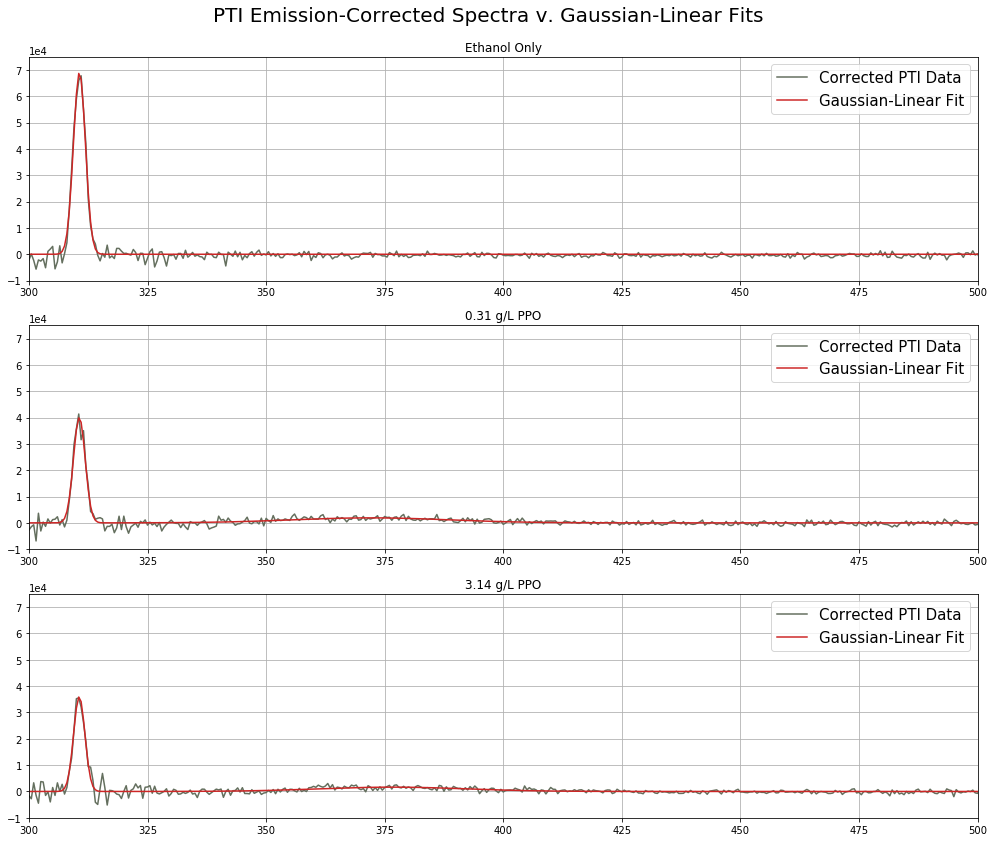

In [139]:
fig = plt.figure(figsize = (17,14))
fig.suptitle("PTI Emission-Corrected Spectra v. Gaussian-Linear Fits", fontsize = 20, y = .93)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

titles = ["Ethanol Only", "0.31 g/L PPO", "3.14 g/L PPO"]

for i in range(3):
    ax = [ax1,ax2,ax3][i]
    ax.plot(ppo_data[i].wavelengths, ppo_data[i].cor_data, "#646F5E")
    ax.plot(fit_wavelengths, total_fits[i], "#CD2626")
    ax.legend(["Corrected PTI Data", "Gaussian-Linear Fit"], fontsize = 15)
    ax.set_title(titles[i])
    ax.grid()
    ax.set_xlim([300,500])
    ax.set_ylim([-1e4,7.5e4])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
plt.show()

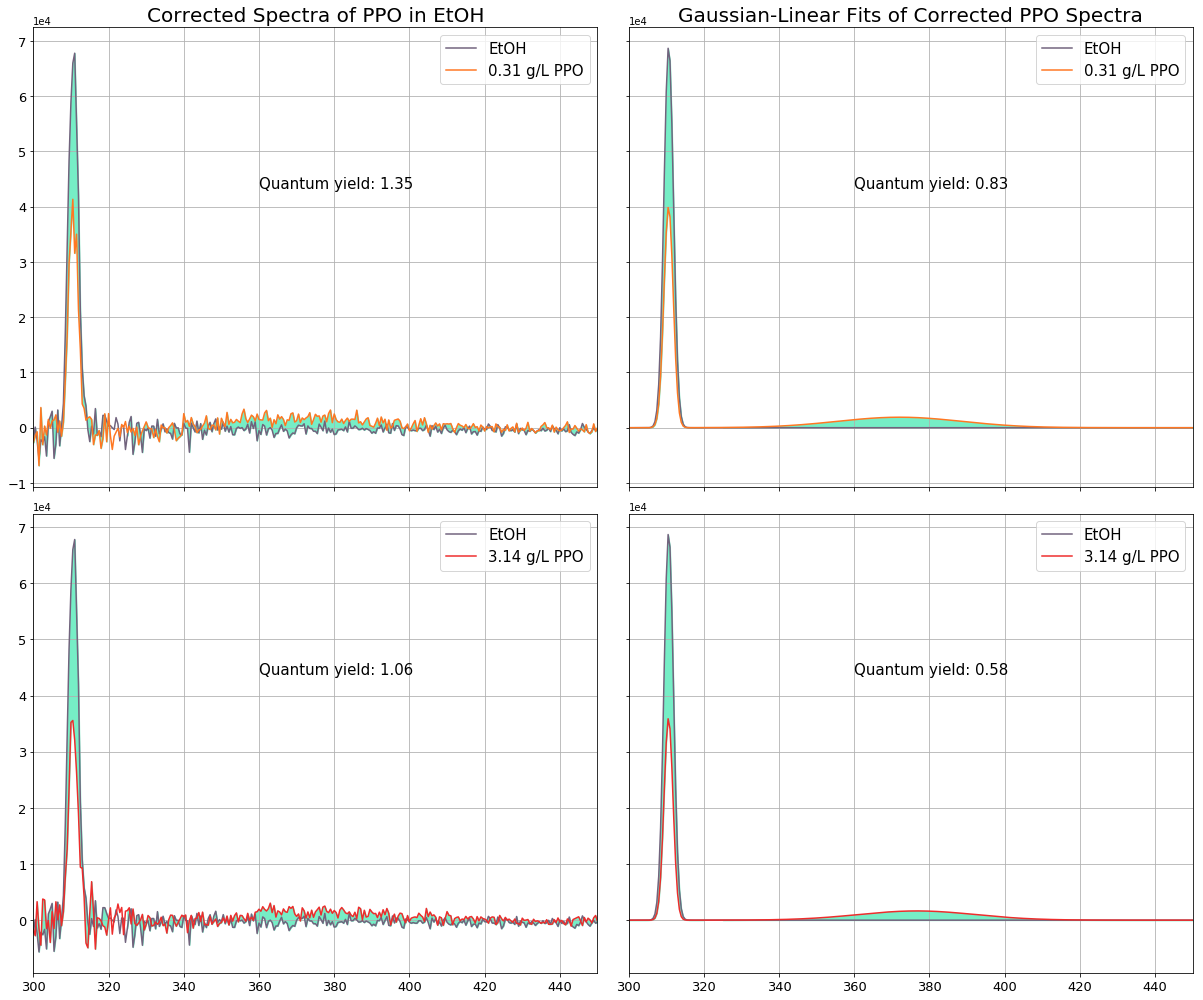

In [160]:
fig = plt.figure(figsize = (17,14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2, sharey = ax1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4, sharey = ax3)

fill_color = "#76EEC6"

ax1.set_title("Corrected Spectra of PPO in EtOH", fontsize = 20)
# ax1.plot(ppo_data[0].wavelengths, ppo_data[0].cor_data - ppo_data[1].cor_data)
ax1.plot(ppo_data[0].wavelengths, ppo_data[0].cor_data,'#71637D')
ax1.plot(ppo_data[1].wavelengths, ppo_data[1].cor_data, '#FF7722')
ax1.tick_params(labelsize = 13., labelbottom = False)
ax1.legend(["EtOH", "0.31 g/L PPO"], fontsize = 15)
ax1.fill_between(ppo_data[0].wavelengths, ppo_data[0].cor_data, ppo_data[1].cor_data,
                 where = ((ppo_data[0].wavelengths >= ex_int_range[0]) &
                          (ppo_data[0].wavelengths <= ex_int_range[1])),
                 color =  fill_color)
ax1.fill_between(ppo_data[0].wavelengths, ppo_data[0].cor_data, ppo_data[1].cor_data,
                 where = ((ppo_data[0].wavelengths >= em_int_range[0]) &
                          (ppo_data[0].wavelengths <= em_int_range[1])),
                 color =  fill_color)

ax2.set_title("Gaussian-Linear Fits of Corrected PPO Spectra", fontsize = 20)
# ax2.plot(fit_wavelengths, total_fits[0]-total_fits[1],'#71637D')
ax2.plot(fit_wavelengths, total_fits[0],'#71637D')
ax2.plot(fit_wavelengths, total_fits[1], '#FF7722')
ax2.tick_params(labelleft = False, labelbottom = False)
ax2.legend(["EtOH", "0.31 g/L PPO"], fontsize = 15)
ax2.fill_between(fit_wavelengths, total_fits[0], total_fits[1],
                 where = ((fit_wavelengths >= ex_int_range[0]) &
                          (fit_wavelengths <= ex_int_range[1])),
                 color =  fill_color)
ax2.fill_between(fit_wavelengths, total_fits[0], total_fits[1],
                 where = ((fit_wavelengths >= em_int_range[0]) &
                          (fit_wavelengths <= em_int_range[1])),
                 color =  fill_color)

# ax3.plot(ppo_data[0].wavelengths, ppo_data[0].cor_data-ppo_data[1].cor_data,'#71637D')
ax3.plot(ppo_data[0].wavelengths, ppo_data[0].cor_data,'#71637D')
ax3.plot(ppo_data[2].wavelengths, ppo_data[2].cor_data,'#EE2C2C')
ax3.tick_params(labelsize = 13.)
ax3.legend(["EtOH", "3.14 g/L PPO"], fontsize = 15)
ax3.fill_between(ppo_data[0].wavelengths, ppo_data[0].cor_data, ppo_data[2].cor_data,
                 where = ((ppo_data[0].wavelengths >= ex_int_range[0]) &
                          (ppo_data[0].wavelengths <= ex_int_range[1])),
                 color =  fill_color)
ax3.fill_between(ppo_data[0].wavelengths, ppo_data[0].cor_data, ppo_data[2].cor_data,
                 where = ((ppo_data[0].wavelengths >= em_int_range[0]) &
                          (ppo_data[0].wavelengths <= em_int_range[1])),
                 color =  fill_color)

# ax4.plot(fit_wavelengths, total_fits[0]-total_fits[2],'#71637D')
ax4.plot(fit_wavelengths, total_fits[0],'#71637D')
ax4.plot(fit_wavelengths, total_fits[2],"#EE2C2C")
ax4.tick_params(labelsize = 13., labelleft = False)
ax4.legend(["EtOH", "3.14 g/L PPO"], fontsize = 15)
ax4.fill_between(fit_wavelengths, total_fits[0], total_fits[2],
                 where = ((fit_wavelengths >= ex_int_range[0]) &
                          (fit_wavelengths <= ex_int_range[1])),
                 color =  fill_color)
ax4.fill_between(fit_wavelengths, total_fits[0], total_fits[2],
                 where = ((fit_wavelengths >= em_int_range[0]) &
                          (fit_wavelengths <= em_int_range[1])),
                 color =  fill_color)

for i in range(4):
    ax = [ax1, ax2, ax3, ax4][i]
    ax.text(0.4, 0.65, "Quantum yield: %.2f" %QYs[i], transform=ax.transAxes, fontsize = 15)
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlim([300, 450])

plt.tight_layout()
plt.show()

## PPO in Cyclohexane, 5 July 2016 (Sphere)

In [145]:
prefix = "Henry/Emission/"


ppo_data_sets  =     [PTIData(prefix + "cyclo25Jul5.txt"),
                      PTIData(prefix + "pt04mMPPOcyclo25Jul5.txt"),
                      PTIData(prefix + "pt43mMPPOcyclo25Jul5.txt")
                     ]

baseline_ranges = [[475,600]]
emcorr_wavelengths = np.arange(300, 848+1.0, 1)
where = np.where((emcorr_wavelengths >= 300) & (emcorr_wavelengths <= 600))
emcorr_quanta_sphere_values = np.loadtxt("PTI/correction_data/emcorr-sphere-quanta_1x0_nm_step.txt")
emcorr_from_file = emcorr_quanta_sphere_values[where]

emcorr = False
for data_set in ppo_data_sets :
    # Subtract a linear baseline fit from the data
    data_set.cor_data = spec_fit.get_linear_subtracted(data_set, poly_deg=1, list_of_ranges=baseline_ranges)
    
    # Apply emission correction
    if emcorr:
        data_set.cor_data = data_set.cor_data * emcorr_from_file


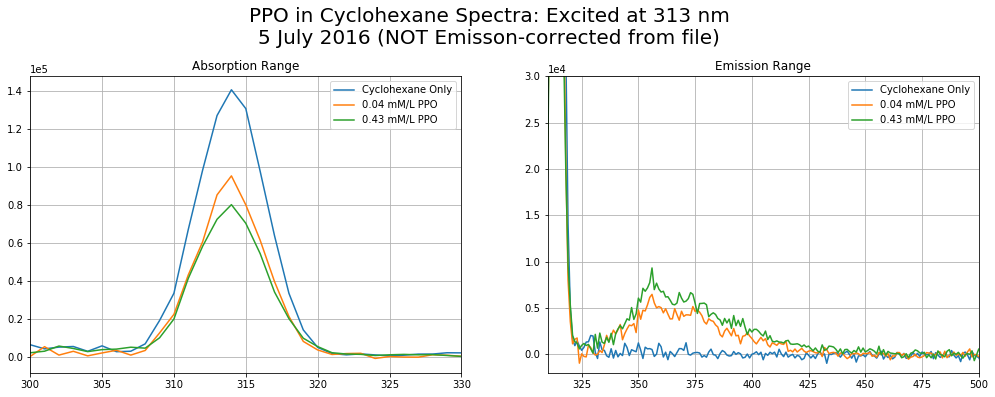

In [146]:
emcorr_text = ["NOT ", ""]

fig = plt.figure(figsize = (17,12))
fig.suptitle("PPO in Cyclohexane Spectra: Excited at 313 nm\n"+
             "5 July 2016 (%sEmisson-corrected from file)" %emcorr_text[emcorr], y = .96, fontsize=20)

all_ex = fig.add_subplot(2,2,1)
all_em = fig.add_subplot(2,2,2)
for i in range(3):
    all_ex.plot(ppo_data_sets[i].wavelengths, ppo_data_sets[i].cor_data)
    all_em.plot(ppo_data_sets[i].wavelengths, ppo_data_sets[i].cor_data)
    
    all_ex.set_xlim([300,330])
    
    all_em.set_xlim([310,500])
    all_em.set_ylim([-.2e4,30000])

all_ex.set_title("Absorption Range")
all_em.set_title("Emission Range")
all_ex.legend(["Cyclohexane Only", "0.04 mM/L PPO", "0.43 mM/L PPO"])
all_em.legend(["Cyclohexane Only", "0.04 mM/L PPO", "0.43 mM/L PPO"])

all_ex.grid()
all_ex.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
all_em.grid() 
all_em.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

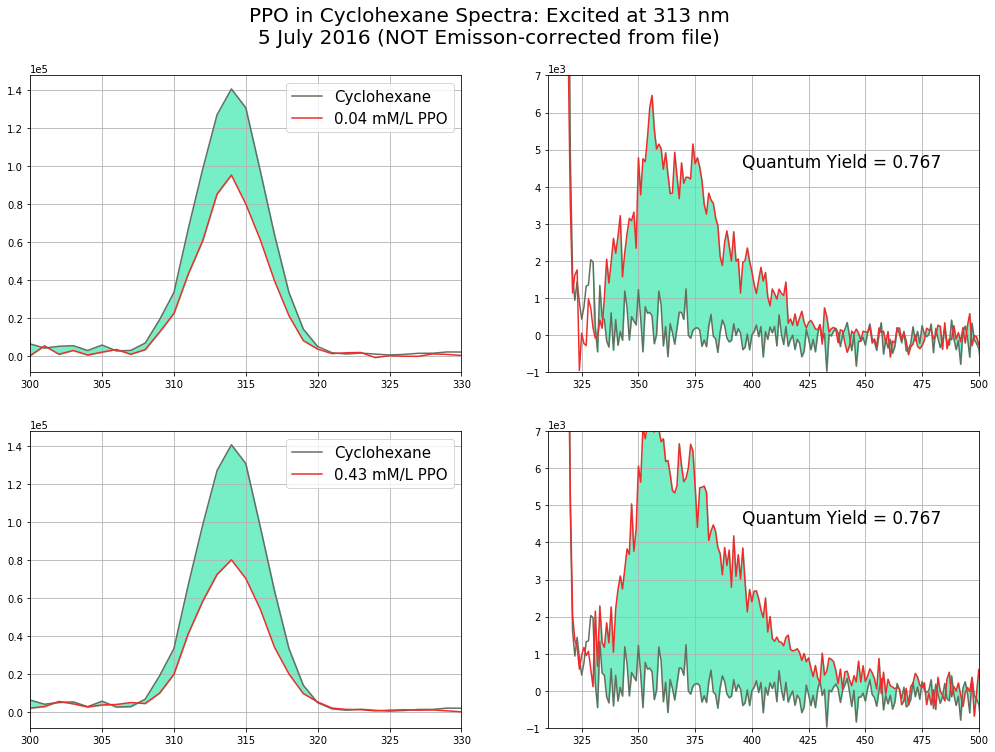

In [148]:
ex_int_range = [300,320]
em_int_range = [330,500]
QYs = list()
    
QYs.append(qy.calc_QY_PTI(ppo_data_sets[0], ppo_data_sets[1], 
                          ex_int_range, em_int_range))
QYs.append(qy.calc_QY_PTI(ppo_data_sets[0], ppo_data_sets[2], 
                          ex_int_range, em_int_range))
fill_color = "#76EEC6"

emcorr_text = ["NOT ", ""]
fig = plt.figure(figsize = (17,12))
fig.suptitle("PPO in Cyclohexane Spectra: Excited at 313 nm\n"+
             "5 July 2016 (%sEmisson-corrected from file)" %emcorr_text[emcorr], y = .96, fontsize=20)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


left = [ax1,ax3]
right = [ax2,ax4]
concentrations = ["0.04 mM/L PPO", "0.43 mM/L PPO"]

for i in range(2):
    left_ax = left[i]
    right_ax = right[i]
    
    left_ax.plot(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, "#646F5E")
    left_ax.plot(ppo_data_sets[i+1].wavelengths, ppo_data_sets[i+1].cor_data, "#EE2C2C")
    left_ax.set_xlim([300,330])
    left_ax.fill_between(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, ppo_data_sets[i+1].cor_data,
                 where = ((ppo_data_sets[0].wavelengths >= ex_int_range[0]) &
                          (ppo_data_sets[0].wavelengths <= ex_int_range[1])),
                 color =  fill_color)
    
    right_ax.plot(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, "#646F5E")
    right_ax.plot(ppo_data_sets[i+1].wavelengths, ppo_data_sets[i+1].cor_data, "#EE2C2C")
    right_ax.set_xlim([310,500])
    right_ax.set_ylim([-1000,7000])
    right_ax.fill_between(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, ppo_data_sets[i+1].cor_data,
                 where = ((ppo_data_sets[0].wavelengths >= em_int_range[0]) &
                          (ppo_data_sets[0].wavelengths <= em_int_range[1])),
                 color =  fill_color)
    right_ax.text(0.45, 0.69,"Quantum Yield = %0.3f" %QYs[0], transform=right_ax.transAxes,fontsize = 17)
    
    left_ax.legend(["Cyclohexane", concentrations[i]], fontsize = 15)
    
for ax in left+right:
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


## PPO in Cyclohexane, 7 July 2016 (Sphere)

In [140]:
prefix = "Henry/Emission/PPOcyclo/Jul7/"


ppo_data_sets  =     [PTIData(prefix + "cyclo2pt5g.txt"),
                      PTIData(prefix + "pt04mMPPOcyclo2pt5g.txt"),
                      PTIData(prefix + "pt43mMPPOcyclo2pt5g.txt"),
                      PTIData(prefix + "4pt3mMPPOcyclo2pt5g.txt")
                     ]

baseline_ranges = [[475,600]]
emcorr_wavelengths = np.arange(300, 848+1.0, 1.0)
where = np.where((emcorr_wavelengths >= 300) & (emcorr_wavelengths <= 600))
emcorr_quanta_sphere_values = np.loadtxt("PTI/correction_data/emcorr-sphere-quanta_1x0_nm_step.txt")
emcorr_from_file = emcorr_quanta_sphere_values[where]

ex_fit_ranges = [[325,375]]
em_fit_ranges = [[375, 475]]
fit_wavelengths = np.arange(300, 650, 0.5)
ex_fits = list()
em_fits = list()
total_fits = list()

for data_set in ppo_data_sets :
    # Subtract a linear baseline fit from the data
    data_set.cor_data = spec_fit.get_linear_subtracted(data_set, poly_deg=1, list_of_ranges=baseline_ranges)
    
    # Apply emission correction
    data_set.cor_data = data_set.cor_data * emcorr_from_file


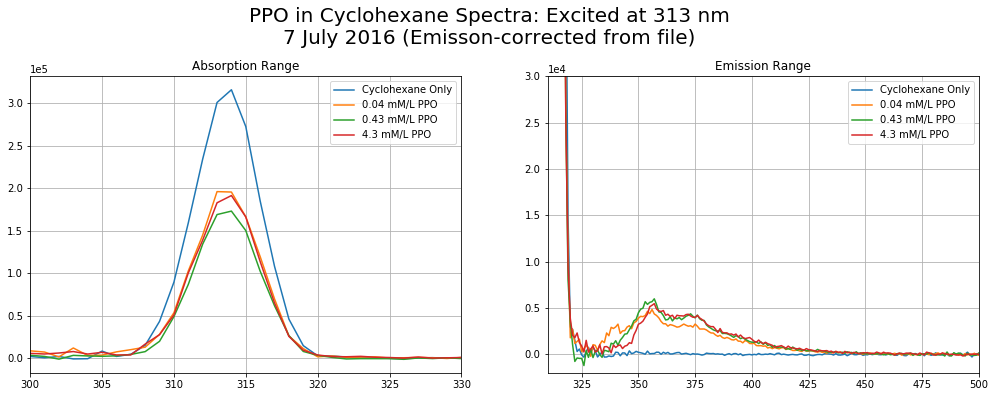

In [143]:
fig = plt.figure(figsize = (17,12))
fig.suptitle("PPO in Cyclohexane Spectra: Excited at 313 nm\n"+
             "7 July 2016 (Emisson-corrected from file)", y = .96, fontsize=20)

all_ex = fig.add_subplot(2,2,1)
all_em = fig.add_subplot(2,2,2)
for i in range(4):
    all_ex.plot(ppo_data_sets[i].wavelengths, ppo_data_sets[i].cor_data)
    all_em.plot(ppo_data_sets[i].wavelengths, ppo_data_sets[i].cor_data)
    
    all_ex.set_xlim([300,330])
    
    all_em.set_xlim([310,500])
    all_em.set_ylim([-.2e4,30000])

all_ex.set_title("Absorption Range")
all_em.set_title("Emission Range")
all_ex.legend(["Cyclohexane Only", "0.04 mM/L PPO", "0.43 mM/L PPO", "4.3 mM/L PPO"])
all_em.legend(["Cyclohexane Only", "0.04 mM/L PPO", "0.43 mM/L PPO","4.3 mM/L PPO"])

all_ex.grid()
all_ex.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
all_em.grid() 
all_em.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

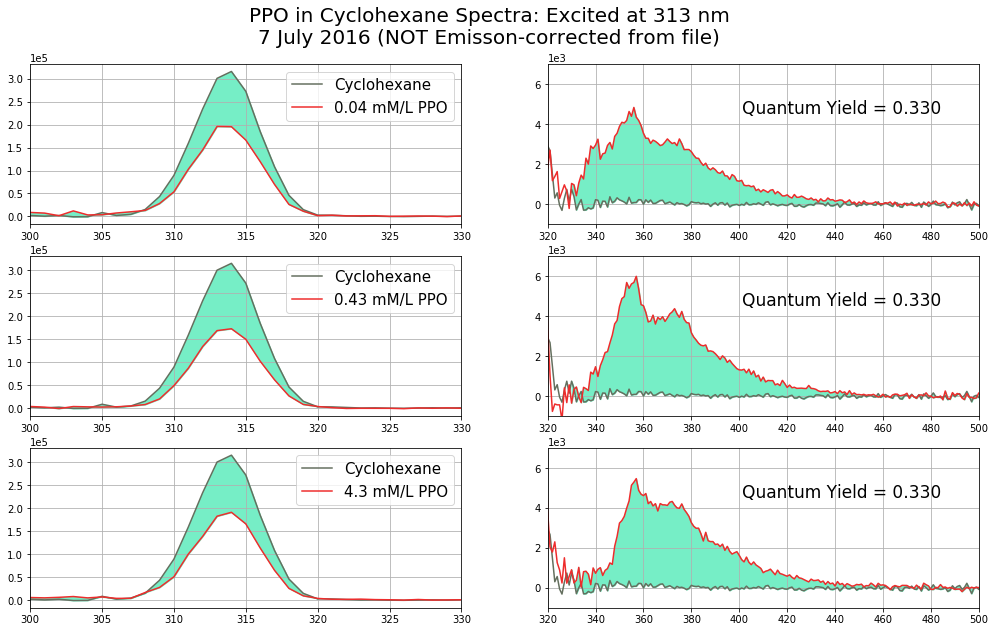

In [144]:
ex_int_range = [300,320]
em_int_range = [330,500]
QYs = list()
    
QYs.append(qy.calc_QY_PTI(ppo_data_sets[0], ppo_data_sets[1], 
                          ex_int_range, em_int_range))
QYs.append(qy.calc_QY_PTI(ppo_data_sets[0], ppo_data_sets[2], 
                          ex_int_range, em_int_range))
QYs.append(qy.calc_QY_PTI(ppo_data_sets[0], ppo_data_sets[3], 
                          ex_int_range, em_int_range))

fill_color = "#76EEC6"
fig = plt.figure(figsize=(17,10))
fig.suptitle("PPO in Cyclohexane Spectra: Excited at 313 nm\n"+
             "7 July 2016 (NOT Emisson-corrected from file)", y = .96, fontsize=20)
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)

left = [ax1,ax3, ax5]
right = [ax2,ax4,ax6]
concentrations = ["0.04 mM/L PPO", "0.43 mM/L PPO","4.3 mM/L PPO"]

for i in range(3):
    left_ax = left[i]
    right_ax = right[i]
    
    left_ax.plot(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, "#646F5E")
    left_ax.plot(ppo_data_sets[i+1].wavelengths, ppo_data_sets[i+1].cor_data, "#EE2C2C")
    left_ax.set_xlim([300,330])
    left_ax.fill_between(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, ppo_data_sets[i+1].cor_data,
                 where = ((ppo_data_sets[0].wavelengths >= ex_int_range[0]) &
                          (ppo_data_sets[0].wavelengths <= ex_int_range[1])),
                 color =  fill_color)
    left_ax.legend(["Cyclohexane", concentrations[i]], fontsize = 15)

    
    right_ax.plot(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, "#646F5E")
    right_ax.plot(ppo_data_sets[i+1].wavelengths, ppo_data_sets[i+1].cor_data, "#EE2C2C")
    right_ax.set_xlim([320,500])
    right_ax.set_ylim([-1000, 7000])
    right_ax.fill_between(ppo_data_sets[0].wavelengths, ppo_data_sets[0].cor_data, ppo_data_sets[i+1].cor_data,
                 where = ((ppo_data_sets[0].wavelengths >= em_int_range[0]) &
                          (ppo_data_sets[0].wavelengths <= em_int_range[1])),
                 color =  fill_color)
    right_ax.text(0.45, 0.69,"Quantum Yield = %0.3f" %QYs[0], transform=right_ax.transAxes,fontsize = 17)
    
for ax in left+right:
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


## 4.47 mg/L bisMSB in LAB

In [92]:
prefix = "Henry/Sphere/bisMSB_LAB/"

bisMSB_data_sets  =  [PTIData(prefix + "EmissionScan_LAB_ex350_2sec_160823.txt"),
                      PTIData(prefix + "EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec_160824.txt"),
                      PTIData(prefix + "EmissionScan_LAB_ex360_2sec_160823.txt"),
                      PTIData(prefix + "EmissionScan_bisMSBinLAB_4.47mgL_ex360_2sec_160824.txt"),
                      PTIData(prefix + "EmissionScan_LAB_ex370_2sec_160823.txt"),
                      PTIData(prefix + "EmissionScan_bisMSBinLAB_4.47mgL_ex370_2sec_160824.txt"),
                      PTIData(prefix + "EmissionScan_LAB_ex380_2sec_160823.txt"),
                      PTIData(prefix + "EmissionScan_bisMSBinLAB_4.47mgL_ex380_2sec_160824.txt")]

baseline_ranges = [[300,330], [475,650]]
emcorr_wavelengths = np.arange(300, 848+0.5, 0.5)
where = np.where((emcorr_wavelengths >= 300) & (emcorr_wavelengths <= 650))
emcorr_from_file = np.loadtxt("PTI/correction_data/emcorr-sphere-quanta-interpolated.txt")[where]

for data_set in bisMSB_data_sets:
    # Subtract a linear baseline fit from the data
    data_set.cor_data = spec_fit.get_linear_subtracted(data_set, poly_deg=1, list_of_ranges=baseline_ranges)
    
    # Apply emission correction
    data_set.cor_data = data_set.cor_data * emcorr_from_file

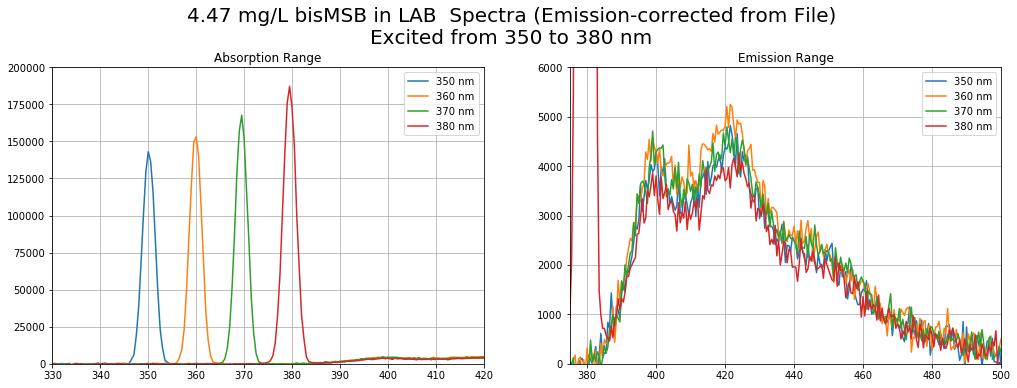

In [93]:
fig = plt.figure(figsize = (17,12))
fig.suptitle("4.47 mg/L bisMSB in LAB  Spectra (Emission-corrected from File)\n"+
             "Excited from 350 to 380 nm", fontsize = 20, y = .95)

all_ex = fig.add_subplot(2,2,1)
all_em = fig.add_subplot(2,2,2)
for i in range(4):
    all_ex.plot(bisMSB_data_sets[(2*i)+1].wavelengths, bisMSB_data_sets[(2*i)+1].cor_data)
    all_em.plot(bisMSB_data_sets[(2*i)+1].wavelengths, bisMSB_data_sets[(2*i)+1].cor_data)
    
    all_ex.set_xlim([330,420])
    all_ex.set_ylim([0,200000])
    
    all_em.set_xlim([375,500])
    all_em.set_ylim([0,6000])

all_ex.set_title("Absorption Range")
all_em.set_title("Emission Range")
all_ex.legend(["350 nm", "360 nm", "370 nm", "380 nm"])
all_em.legend(["350 nm", "360 nm", "370 nm", "380 nm"])

all_ex.grid()
all_em.grid()   
plt.show()

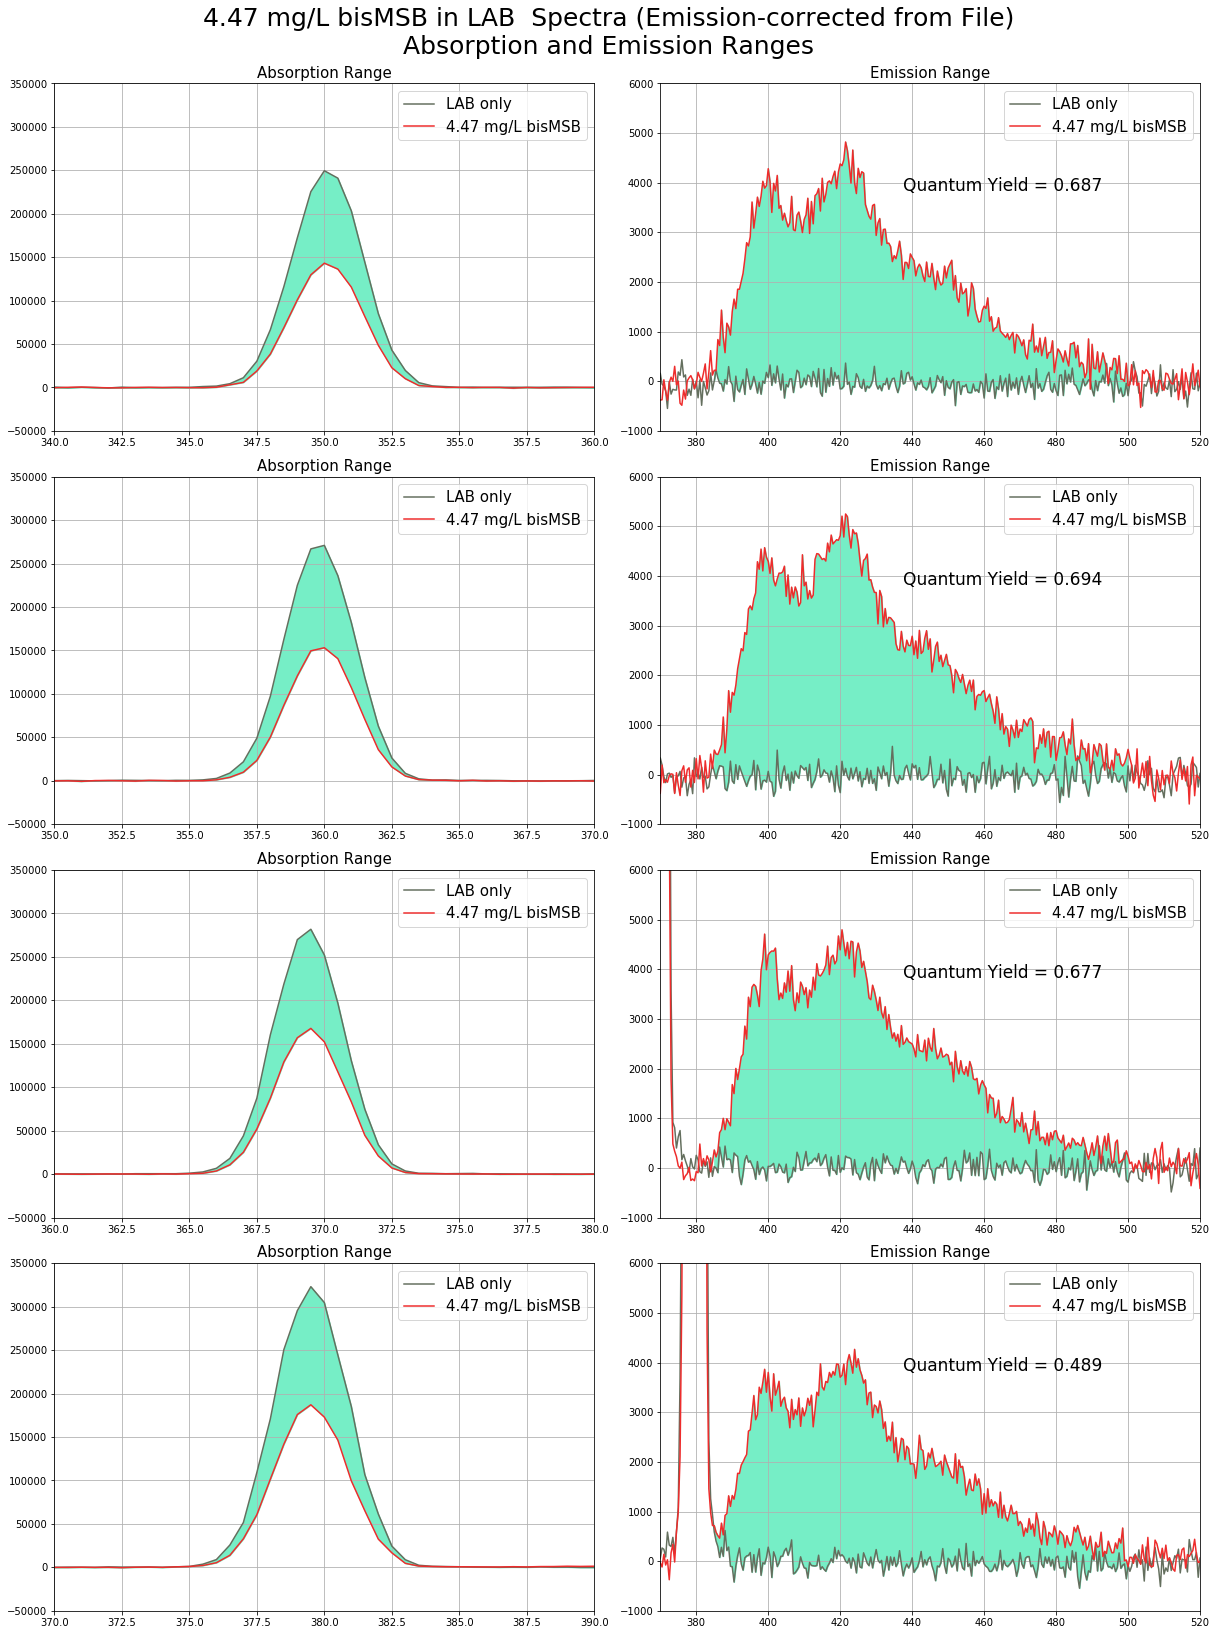

In [100]:
fig = plt.figure(figsize = (17,22))
fig.suptitle("4.47 mg/L bisMSB in LAB  Spectra (Emission-corrected from File)\n"+
             "Absorption and Emission Ranges", fontsize = 25, y = 1.03)

ax1 = fig.add_subplot(4,2,1)
ax2 = fig.add_subplot(4,2,2)
ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)
ax5 = fig.add_subplot(4,2,5)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

left = [ax1,ax3,ax5,ax7]
right = [ax2,ax4,ax6,ax8]
ex_wavelengths = [350,360,370,380]


ex_plus_minus = 15
em_int_range = [385,500]
QYs = list()

for i in range(4):
    ex_int_range = [ex_wavelengths[i] - 10, ex_wavelengths[i] + 10]
    QYs.append(qy.calc_QY_PTI(bisMSB_data_sets[2*i], bisMSB_data_sets[(2*i)+1], 
                          ex_int_range, em_int_range))
    
    ax = left[i]
    ax.set_title("Absorption Range", fontsize=15)
    ax.plot(bisMSB_data_sets[2*i].wavelengths, bisMSB_data_sets[2*i].cor_data, "#646F5E")
    ax.plot(bisMSB_data_sets[(2*i)+1].wavelengths, bisMSB_data_sets[(2*i)+1].cor_data, "#EE2C2C")
    ax.set_xlim([ex_wavelengths[i] - 10, ex_wavelengths[i] + 10])
    ax.set_ylim([-50000,350000])
    ax.fill_between(bisMSB_data_sets[2*i].wavelengths, bisMSB_data_sets[2*i].cor_data, bisMSB_data_sets[(2*i)+1].cor_data,
            where = ((bisMSB_data_sets[2*i].wavelengths >= ex_int_range[0]) &
                     (bisMSB_data_sets[2*i].wavelengths <= ex_int_range[1])),
             color =  fill_color)
    ax.legend(["LAB only", "4.47 mg/L bisMSB"], fontsize=15)
    ax.grid()
    
    ax = right[i]
    ax.set_title("Emission Range", fontsize=15)
    ax.plot(bisMSB_data_sets[2*i].wavelengths, bisMSB_data_sets[2*i].cor_data, "#646F5E")
    ax.plot(bisMSB_data_sets[(2*i)+1].wavelengths, bisMSB_data_sets[(2*i)+1].cor_data, "#EE2C2C")
    ax.set_xlim([370, 520])
    ax.set_ylim([-1000,6000])
    ax.text(0.45, 0.69,"Quantum Yield = %0.3f" %QYs[i], transform=ax.transAxes,fontsize = 17)
    ax.fill_between(bisMSB_data_sets[2*i].wavelengths, bisMSB_data_sets[2*i].cor_data, bisMSB_data_sets[(2*i)+1].cor_data,
                    where = ((bisMSB_data_sets[2*i].wavelengths >= em_int_range[0]) &
                             (bisMSB_data_sets[2*i].wavelengths <= em_int_range[1])),
                    color =  fill_color)
    ax.legend(["LAB only", "4.47 mg/L bisMSB"], fontsize=15)
    ax.grid()
    

plt.tight_layout()    
plt.show()